# Integral Control Analysis

# Preliminaries

## Imports

In [1]:
import collections
import tellurium as te
import sympy
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
import numpy as np
from common_python.sympy import sympyUtil as su
from common_python.ODEModel.ODEModel import ODEModel

## Constants

In [2]:
def initSymbols():
    symbols = "dA A A_ref K_AN K_AM N K_PA K_MP rd_A rd_A1 K1 K2 K3 K4 K_A2 Kd_A Kd_M Kd_P K_Mp A M Mp dP P K_P k_0 M dM K_M rd_M k_0"
    su.addSymbols(symbols, dct=globals())

initSymbols()
EQUATION_VARS = [P, M, A]

In [3]:
STATE_DCT = {
     A: K_AN * N - Kd_A * A * M,
     P: K_PA * A - k_0,
     M: K_MP * P - Kd_M * M,
}
SUBS = {Kd_A: 1, K_MP: 1, K_PA: 1, k_0: 2.0, Kd_M: 1, N: 1, K_AN: 1, Kd_M: 1, Kd_A: 1, Kd_P: 1, K_AM: 1}

# Helper Functions

In [4]:
def mkSymbolStmt(symbolStr):
  """
  Creaes an executable statement that defines the blank separated symbols in the string.
  """
  symbols = symbolStr.split(" ")
  quotedStrs = ["%s" %s for s in symbols]
  argStrs = ", ".join(symbols)
  return "%s = sympy.symbols(%s)" % (argStrs, quotedStrs)

# Tests
variables = ["aa", "bbb", "fruit"]
symbolStr = " ".join(variables)
stmt = mkSymbolStmt(symbolStr)
exec(stmt)
for variable in variables:
  assert(variable in locals())
  delStmt = "del %s" % variable
  exec(delStmt)

In [5]:
def evaluate(expression, subs):
    result = expression.copy()
    for symbol, value in subs.items():
        result = result.subs(symbol, value)
    return sympy.simplify(result)

# Tests
initSymbols()
dA = A + A * M
result = evaluate(dA, {A: 1})
assert(result == 1 + M)

In [6]:
def initEquations():
  """
  Constructs equations for network A where M inhibits A
  """
  statements = [
      "dA = K_AN * N - Kd_A * A * M",
      "dP = K_PA * A - k_0 ",
      "dM = K_MP * P - Kd_M * M",
      "equationDct = {A: dA, P: dP, M: dM}",
  ]
  return "; ".join(statements)

exec(initEquations())

In [7]:
def mkEquationVec(equationDct, equationVars=[P, M, A]):
    return sympy.Matrix([equationDct[s] for s in equationVars])

# Tests
exec(initEquations())
vec = mkEquationVec(equationDct)
assert(len(vec) == 3)
assert(isinstance(vec, sympy.Matrix))

In [8]:
def calcJacobian(equationDct, fixedDct, equationVars=[P, M, A], **kwargs):
    """
    Calculates the Jacobian at the fixed point and evaluates it.
    
    Parameters
    ----------
    equationDct: key: Symbol, value: expression
    fixedDct: key: Symbol, value: expression/number
    varVec: vector of variable (symbols) that correspond to the equations
    kwargs: dict
        optional arguments for evaluate
        
    Returns
    -------
    sympy.Matrix
    """
    equationVec = mkEquationVec(equationDct, equationVars)
    # Calculate fixed points and eigenvectors
    jacobianMat = equationVec.jacobian(equationVars)
    jacobianMat = su.evaluate(jacobianMat, subs=fixedDct, isNumpy=False)
    if len(kwargs) > 0:
        jacobianMat = su.evaluate(jacobianMat, **kwargs)
    return jacobianMat

# Tests
exec(initEquations())
fixedDct = {A:101, M: 1001}
resultMat = calcJacobian(equationDct , fixedDct, isNumpy=False)
assert(resultMat[2, 2] == -1001.0 * Kd_A)
assert((resultMat.rows == 3) and (resultMat.cols ==3))

In [9]:
# eqn: equations for model
# var: variable names
# fps: list-FixedPointInfo
# jac: jacobian
# eig: eigenvalues
# fp: list-dct of fixed points
ModelInfo = collections.namedtuple("ModelInfo", "eqn var fps")
FixedPointInfo = collections.namedtuple("FixedPointInfo", "jac eig fp")
def calcModelInfo(equationDct, equationVars=EQUATION_VARS, subs={}):
    """
    Construct various information for a model.
    
    Parameters
    ----------
    equationDct: dict
        key: state
        value: expression
    equationVars: list-symbol
        state variables
    subs: dict
    
    Returns
    -------
    ModelInfo
    """
    def mkFixedDcts(fixedPoints):
        def mkDct(points):
            if isinstance(points, dict):
                return points
            return {v: p for p, v in zip(points, equationVars)}
        #
        if isinstance(fixedPoints, dict):
            fixedDcts = [mkDct(fixedPoints)]
        else:
            fixedDcts = []
            for fixedPoint in fixedPoints:
                fixedDcts.append(mkDct(fixedPoint))
        return fixedDcts
    #
    modelInfos = []
    equationVec = mkEquationVec(equationDct, equationVars)
    # Calculate the fixed points
    fixedPoints = sympy.solve(equationVec, equationVars)
    fixedDcts = mkFixedDcts(fixedPoints)
    # Calculate the Jacobian
    fps = []
    for fixedDct in fixedDcts:
        jacobianMat = calcJacobian(equationDct, fixedDct, isNumpy=False)
        eigenValues = list(jacobianMat.eigenvals().keys())
        fps.append(FixedPointInfo(fp=fixedDct, jac=jacobianMat, eig=eigenValues))
    # Construct the ModelInfo
    return ModelInfo(eqn=equationDct, var=equationVars, fps=fps)

# Tests
exec(initEquations())
result = calcModelInfo(equationDct)
eigenvalues = [su.evaluate(e, subs=SUBS) for e in result.fps[0].eig]
assert(eigenvalues[0] < 0)
assert(len(eigenvalues) == 3)

# Implementation of integral feedback control in biological systems
## Reference
Authors: 
Somvanshi, Pramod R.
Patel, Anilkumar K.
Bhartiya, Sharad
Venkatesh, K. V.

Date: 2015

## Analysis

[Feedback Designs](https://drive.google.com/file/d/1GT2hfqxUAo8iiLutB4ccp_mMl59KB8OH/view?usp=sharing)

* $P$ - protein
* $A$ - signaling molecule
* $M$ - metabolite
* $N$ - disturbance
* $E = A_{ref} - A$
* $A_{ref} = \frac{k_0}{K_P}$

* $P \xrightarrow{k_0}\phi$
* $\phi \xrightarrow{K_M P} M$
* $A \xrightarrow{Kd_A A M} \phi$
* $N \xrightarrow{K_A} A$
* $\phi \xrightarrow{K_P A} P$

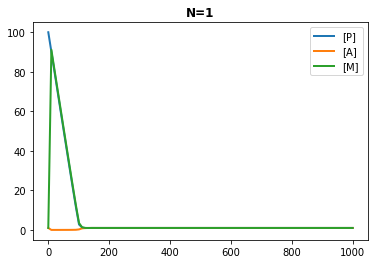

Final A = 1.00


In [10]:
NET_A = """

J1: P -> ; k_0
J3: -> P; K_P * A
J2: -> M; K_M * P
J2a: M ->; Kd_M * M
J4: A -> ; Kd_A * A * M
J5: $N -> A; K_A * N

$N = 1
P = 100
M = 1
A = 1
K_N = 1
k_0 = 1
K_M = 1
Kd_M = 1
K_P = 1
Kd_A = 1
K_A = 1
"""

rr = te.loada(NET_A)
rr.plot(rr.simulate(0, 1000, 100), title="N=%d" % rr.N)
print("Final A = %2.2f" % rr.A)

### Revised Network A

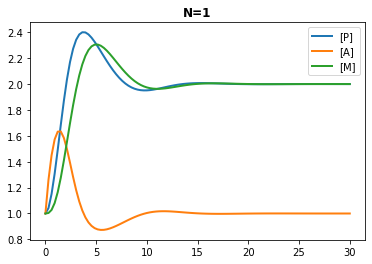

Final A = 1.00


In [11]:
# Have a source of A other than N
NET_A1 = """

J1: P -> ; k_0
J3: -> P; K_P * A
J2: -> M; K_M * P
J2a: M ->; Kd_M * M
J4: A -> ; Kd_A * A * M
J4a: -> A; k_1
J5: $N -> A; K_A * N

$N = 1
P = 1
M = 1
A = 1
K_N = 1
k_0 = 1
K_M = 1
Kd_M = 1
K_P = 1
Kd_A = 1
K_A = 1
k_1 = 1
"""

rr = te.loada(NET_A1)
rr.plot(rr.simulate(0, 30, 100), title="N=%d" % rr.N)
print("Final A = %2.2f" % rr.A)

### Changing $k_0$

Vary k_0 from 0.5 to 3.
Plot fixed points and how they change type.

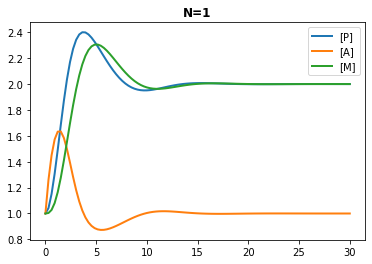

Final A = 1.00


In [12]:
# Have a source of A other than N
NET_A1 = """

J1: P -> ; k_0
J3: -> P; K_P * A
J2: -> M; K_M * P
J2a: M ->; Kd_M * M
J4: A -> ; Kd_A * A * M
J4a: -> A; k_1
J5: $N -> A; K_A * N

$N = 1
P = 1
M = 1
A = 1
K_N = 1
k_0 = 1
K_M = 1
Kd_M = 1
K_P = 1
Kd_A = 1
K_A = 1
k_1 = 1
"""

rr = te.loada(NET_A1)
rr.plot(rr.simulate(0, 30, 100), title="N=%d" % rr.N)
print("Final A = %2.2f" % rr.A)

In [13]:
K0_VALS = [0.5, 0.75, 1.0, 1.5, 2.0, 2.5]

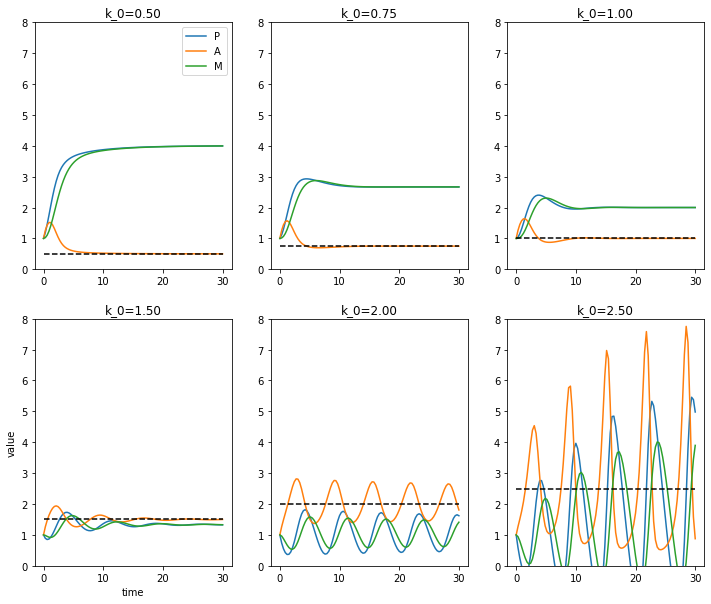

In [14]:
def plotk0(model, k0Vals=K0_VALS):
    numCol = 3
    fig, axes = plt.subplots(2, numCol, figsize=(12, 10))
    for idx, k_0 in enumerate(k0Vals):
        if idx < numCol:
            ax = axes[0, idx]
        else:
            ax = axes[1, idx - numCol]
        rr =  te.loada(model)
        rr.k_0 = k_0
        data = rr.simulate(0, 30, 100)
        xv = data[:, 0]
        columns = [s[1:-1] for s in data.colnames[1:]]
        for idx1, column in enumerate(columns):
            ax.plot(xv, data[:, idx1+1])
        ax.plot(xv, np.repeat(k_0, len(xv)), linestyle="--", color="black")
        if idx == 0:
            ax.legend(columns)
        if idx == numCol:
            ax.set_xlabel("time")
            ax.set_ylabel("value")
        ax.set_title("k_0=%2.2f" % k_0)
        ax.set_ylim([0, 8])
        
# Tests
plotk0(NET_A1)

In [15]:
def calcEigenVals(xVec, dxVec, subs):
    """
    Calculates the eigenvectors of the linearized derivative matrix
    at the substituted values.
    
    Parameters
    ----------
    xVec: sympy.Mat N X 1
        symbols for states
    dxVec: sympy.Mat N X 1
        expressions for derivatives of state
    subs: dict
        substitutions to make for eigenvalue calculation
        key: symbol
        value: value to use for symbol
        
    Returns
    -------
    dict
        key: sympy.Matrix N X 1
            fixed point
        value: sympy.Matrix N X 1
            eigenvalues
    """
    jacobianMat = dxVec.jacobian(xVec)
    fixedPoints = sympy.solve(dxVec, xVec)
    dct = {}
    jacobianMat = evaluate(jacobianMat, subs)
    for fixedPoint in fixedPoints:
        numericFixedPoint = tuple([sympy.simplify(evaluate(f, subs)) for f in fixedPoint])
        fixedSubs = {s: v for s, v in zip(xVec, numericFixedPoint)}
        mat = evaluate(jacobianMat, fixedSubs)
        mat = evaluate(mat, subs)
        dct[numericFixedPoint] = sympy.Matrix(list(mat.eigenvals().keys()))
        dct[numericFixedPoint] = dct[numericFixedPoint].evalf()
    return dct

# Tests
initSymbols()
exec(initEquations())
xVec = sympy.Matrix([A, P, M])
dxVec = mkEquationVec(equationDct, equationVars=[A, P, M])
#dxVec = sympy.Matrix(equations)
dct = calcEigenVals(xVec, dxVec, SUBS)
assert(list(dct.keys()) == [(2.0, 0.5, 0.5)])

In [16]:
# Analysis of fixed points

subs = dict(SUBS)
for val in K0_VALS:
    initSymbols()
    subs[k_0] = val
    xVec = sympy.Matrix([A, P, M])
    equationVec = mkEquationVec(equationDct, equationVars=xVec)
    dxVec = sympy.Matrix(equationVec)
    dct = calcEigenVals(xVec, dxVec, subs)
    print(dct)

{(0.500000000000000, 2.00000000000000, 2.00000000000000): Matrix([
[-2.19148788395312 - 2.53459329291848e-64*I],
[  -0.404256058023441 - 0.254425889416369*I],
[  -0.404256058023441 + 0.254425889416369*I]])}
{(0.750000000000000, 1.33333333333333, 1.33333333333333): Matrix([
[-1.8284526398601 - 2.49609327051412e-64*I],
[ -0.252440346736618 - 0.588605783081763*I],
[ -0.252440346736618 + 0.588605783081763*I]])}
{(1.00000000000000, 1.00000000000000, 1.00000000000000): Matrix([
[-0.122561166876654 - 0.744861766619744*I],
[-0.122561166876654 + 0.744861766619744*I],
[                       -1.75487766624669]])}
{(1.50000000000000, 0.666666666666667, 0.666666666666667): Matrix([
[0.0512182151373453 - 0.919382383528956*I],
[0.0512182151373453 + 0.919382383528956*I],
[                       -1.76910309694136]])}
{(2.00000000000000, 0.500000000000000, 0.500000000000000): Matrix([
[0.163002589530756 - 1.03378784147109*I],
[0.163002589530756 + 1.03378784147109*I],
[                     -1.8260051790

## Network A

In [17]:
modelA = ODEModel(STATE_DCT, isEigenvecs=False)

In [18]:
for fp in modelA.fixedPoints:
    print(fp.valueDct)
    print(fp.getEigenvalues(subs=SUBS))
    print("\n")

{A: k_0/K_PA, P: K_AN*K_PA*Kd_M*N/(K_MP*Kd_A*k_0), M: K_AN*K_PA*N/(Kd_A*k_0)}
[-1.82600517906151, 0.163002589530756 + 1.03378784147109*I, 0.163002589530756 - 1.03378784147109*I]




## Network B

Network B1 has degrdation of $P$ that depends on $P$. It has two problems:
* Eigenvectors are a funxtion of $M$
* Fixed points are a function of $N$

In [19]:
stateDct = dict(STATE_DCT)
stateDct[A] = K_AN * N - Kd_A*A + K_AM * M
stateDct[P] = -K_PA * A * M  + k_0

In [20]:
modelB1 = ODEModel(stateDct, isEigenvecs=False)

In [21]:
modelB1.jacobianMat

Matrix([
[  -Kd_A,    0,    K_AM],
[-K_PA*M,    0, -A*K_PA],
[      0, K_MP,   -Kd_M]])

In [22]:
modelB1.fixedPoints[0].valueDct[P]

-Kd_M*(K_AN*sqrt(K_PA)*N + sqrt(4*K_AM*Kd_A*k_0 + K_AN**2*K_PA*N**2))/(2*K_AM*K_MP*sqrt(K_PA))

In [23]:
 modelB1.fixedPoints[0].valueDct[M]

-K_AN*N/(2*K_AM) - sqrt(4*K_AM*Kd_A*k_0 + K_AN**2*K_PA*N**2)/(2*K_AM*sqrt(K_PA))

In [24]:
 modelB1.fixedPoints[0].valueDct[A]

K_AN*N/(2*Kd_A) - sqrt(4*K_AM*Kd_A*k_0 + K_AN**2*K_PA*N**2)/(2*sqrt(K_PA)*Kd_A)

Network B2 has degrdation of $P$ that does *not* depend on $P$.
* It has a fixed point for $A$ ad $k_0 / K_{PA}$.
* It has no dependency on the state variables, and so the dynamics are independent of the fixed point. (It is a linear system.)

In [25]:
stateDct = dict(STATE_DCT)
stateDct[A] = K_AN * N - Kd_A*A + K_AM * M
stateDct[P] = -K_PA * A  + k_0

In [26]:
modelB2 = ODEModel(stateDct, isEigenvecs=False)

In [27]:
modelB2.jacobianMat

Matrix([
[-Kd_A,    0,  K_AM],
[-K_PA,    0,     0],
[    0, K_MP, -Kd_M]])

In [28]:
modelB2.fixedPoints[0].valueDct[P]

(-K_AN*K_PA*Kd_M*N + Kd_A*Kd_M*k_0)/(K_AM*K_MP*K_PA)

In [29]:
modelB2.fixedPoints[0].valueDct[M]

(-K_AN*K_PA*N + Kd_A*k_0)/(K_AM*K_PA)

In [30]:
modelB2.fixedPoints[0].valueDct[A]

k_0/K_PA

In [31]:
for fp in modelB2.fixedPoints:
    print(fp.getEigenvalues(subs=SUBS))

[-1.75487766624669, -0.122561166876654 + 0.744861766619744*I, -0.122561166876654 - 0.744861766619744*I]


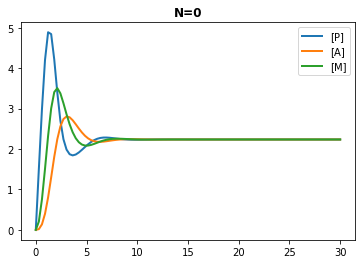

Final A = 2.24


In [32]:
# Have a source of A other than N
NET_B1 = """

J1: -> P ; k_0
J3: P -> ; K_PA * A * P
J2: -> M; K_MP * P
J2a: M ->; Kd_M * M
J4: A -> ; Kd_A * A
J4a: -> A; K_AM*M
J5: $N -> A; K_AN * N

$N = 0
P = 0
M = 0
A = 0
K_AN = 1
k_0 = 5
K_MP = 1
Kd_M = 1
K_PA = 1
Kd_A = 1
K_AM = 1
"""

rr = te.loada(NET_B1)
rr.plot(rr.simulate(0, 30, 100), title="N=%d" % rr.N)
print("Final A = %2.2f" % rr.A)

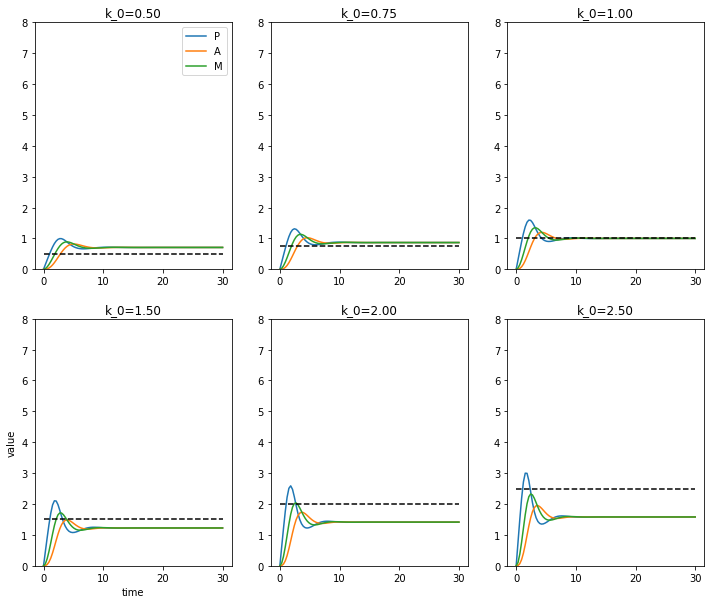

In [33]:
plotk0(NET_B1)

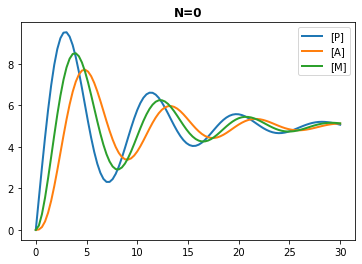

Final A = 5.12


In [34]:
# Have a source of A other than N
NET_B2 = """

J1: -> P ; k_0
J3: P -> ; K_PA * A
J2: -> M; K_MP * P
J2a: M ->; Kd_M * M
J4: A -> ; Kd_A * A
J4a: -> A; K_AM*M
J5: $N -> A; K_AN * N

$N = 0
P = 0
M = 0
A = 0
K_AN = 1
k_0 = 5
K_MP = 1
Kd_M = 1
K_PA = 1
Kd_A = 1
K_AM = 1
"""

rr = te.loada(NET_B2)
rr.plot(rr.simulate(0, 30, 100), title="N=%d" % rr.N)
print("Final A = %2.2f" % rr.A)

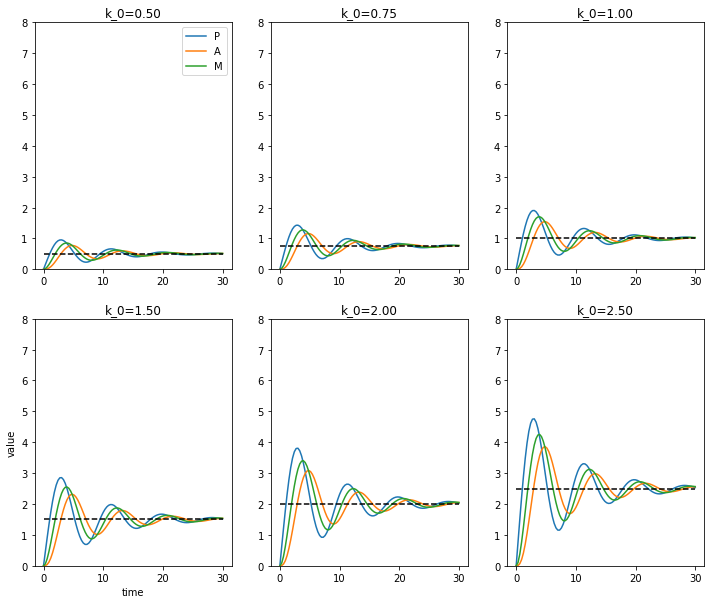

In [35]:
plotk0(NET_B2)

**Observations**
1. Can change $k_0$ without affect Jacobian. However, fixed point depends on $k_0$, and so dynamics are still impacted if there is a change in the setpoint.

## Network C

In [36]:
# Design 1(c): Both M and E inhibit A. Again, need a constant influx so that steady states can be achieved.
exec(initEquations())
dA = - K_AN * N - Kd_A * M + K1
#
result = sympy.solve([dP, dM, dA], [P, M, A])
result

{A: k_0/K_PA, P: (K1*Kd_M - K_AN*Kd_M*N)/(K_MP*Kd_A), M: (K1 - K_AN*N)/Kd_A}

## Network D

In [37]:
# Design 1(d): E inhibits A; A inhibits P; M activates A
exec(initEquations())
dA = K_AM * M - K_AN * N - Kd_A * A
dP = -K_PA * A + k_0  # Since A inhibits, need 0th order kinetics for creation of P
#
result = sympy.solve([dP, dM, dA], [P, M, A])
result

{P: (K_AN*K_PA*Kd_M*N + Kd_A*Kd_M*k_0)/(K_AM*K_MP*K_PA),
 M: (K_AN*K_PA*N + Kd_A*k_0)/(K_AM*K_PA),
 A: k_0/K_PA}

Can construct a table with cases defined by:
* E on A
* M on A
* A on P

Theme: Systematic design of integral control based on:
1. the placement of inhibit vs. activate and use of 0th order kinetics
1. which term(s) have 0th order kinetics

## Tracking for Architecture (a)

In [38]:
exec(initEquations())
dP = K_P * A - k_0 * A_ref
result = sympy.solve([dP, dM, dA], [P, M, A])
result

[(K_AN*K_P*Kd_M*N/(A_ref*K_MP*Kd_A*k_0),
  K_AN*K_P*N/(A_ref*Kd_A*k_0),
  A_ref*k_0/K_P)]

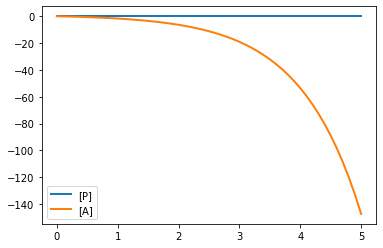

In [39]:
TRACKING_MODEL_A = """
->P; K_P*A
P -> A; K_P * P
A -> P; -KA_1 * A
A ->; KA * $M
// E -> A; KE * A

$M = 1
KP_1 = 1
KP_2 = 1
KA_1 = 1
KA = 1
KE = 1
K_P = 1
"""

rr = te.loada(TRACKING_MODEL_A)
rr.plot(rr.simulate())

# Signaling Cascades

In [40]:
su.addSymbols("A_1 A_2 A_3 A_4 T_1 T_2 T_3 T_4 K_1 K_2 K_3 K_4 k_1 k_2 k_3 k_4 S_0 S_1")

In [41]:
# State equations
stateDct = {
    A_1: K_1 * S_0 * (T_1 - A_1) - k_1 * A_1,
    A_2: K_2 * A_1 * (T_2 - A_2) - k_2 * A_2,
    A_3: K_3 * A_2 * (T_3 - A_3) - k_3 * A_3,
    A_4: K_4 * A_3 * (T_4 - A_4) - k_4 * A_4,
}
modelSig = ODEModel(stateDct, isEigenvecs=False)

In [42]:
fps = modelSig.fixedPoints
len(fps)

1

In [43]:
fps[0].valueDct[A_1]

K_1*S_0*T_1/(K_1*S_0 + k_1)

In [44]:
fps[0].valueDct[A_2]

K_1*K_2*S_0*T_1*T_2/(K_1*K_2*S_0*T_1 + K_1*S_0*k_2 + k_1*k_2)

In [45]:
fps[0].valueDct[A_3]

K_1*K_2*K_3*S_0*T_1*T_2*T_3/(K_1*K_2*K_3*S_0*T_1*T_2 + K_1*K_2*S_0*T_1*k_3 + K_1*S_0*k_2*k_3 + k_1*k_2*k_3)

In [46]:
fps[0].valueDct[A_4]

K_1*K_2*K_3*K_4*S_0*T_1*T_2*T_3*T_4/(K_1*K_2*K_3*K_4*S_0*T_1*T_2*T_3 + K_1*K_2*K_3*S_0*T_1*T_2*k_4 + K_1*K_2*S_0*T_1*k_3*k_4 + K_1*S_0*k_2*k_3*k_4 + k_1*k_2*k_3*k_4)

In [47]:
jacobianMat = modelSig.jacobianMat.subs(fps[0].valueDct)
jacobianMat

Matrix([
[                                                            -K_1*S_0 - k_1,                                                                                                                        0,                                                                                                                                                                                  0,                                                                                                                      0],
[-K_2*(K_1*K_2*S_0*T_1*T_2/(K_1*K_2*S_0*T_1 + K_1*S_0*k_2 + k_1*k_2) - T_2),                                                                                   -K_1*K_2*S_0*T_1/(K_1*S_0 + k_1) - k_2,                                                                                                                                                                                  0,                                                                                                                 

In [48]:
sympy.Matrix([jacobianMat[i,i] for i in range(jacobianMat.rows)])

Matrix([
[                                                                                                        -K_1*S_0 - k_1],
[                                                                                -K_1*K_2*S_0*T_1/(K_1*S_0 + k_1) - k_2],
[                                              -K_1*K_2*K_3*S_0*T_1*T_2/(K_1*K_2*S_0*T_1 + K_1*S_0*k_2 + k_1*k_2) - k_3],
[-K_1*K_2*K_3*K_4*S_0*T_1*T_2*T_3/(K_1*K_2*K_3*S_0*T_1*T_2 + K_1*K_2*S_0*T_1*k_3 + K_1*S_0*k_2*k_3 + k_1*k_2*k_3) - k_4]])

**Observations**
1. Stable system with real eigenvectors.
1. If $K_i >> k_i$, then $A_{i+1} / A_{i} \approx T_{i+1}$ and so $A_n / S_0 \approx \prod_i T_i$

# Push Pull (Cell Systems)

In [49]:
# Push Pull in Cell Systems. Assume n* = 1
su.addSymbols("T_A A B T_B I k_A k_IA k_a k_Ba k_B k_AB k_b")

In [51]:
# State equations
stateDct = {
    A:  (T_A - A) * (k_A + k_IA * I) - A * (k_a + k_Ba * B),
    B: (T_B - B) * (k_B + k_AB * A) - k_b * B
}
modelPushPull = ODEModel(stateDct, isEigenvecs=False, isFixedPoints=False)

In [52]:
stateDct[A].expand()

-A*B*k_Ba - A*I*k_IA - A*k_A - A*k_a + I*T_A*k_IA + T_A*k_A

In [63]:
stateDct[B]

-B*k_b + (-B + T_B)*(A*k_AB + k_B)

In [65]:
solnA = sympy.solve(stateDct[A], [A])[0]
solnA

T_A*(I*k_IA + k_A)/(B*k_Ba + I*k_IA + k_A + k_a)

In [66]:
subsB = stateDct[B].subs({A: solnA})
subsB

-B*k_b + (-B + T_B)*(T_A*k_AB*(I*k_IA + k_A)/(B*k_Ba + I*k_IA + k_A + k_a) + k_B)

In [67]:
solnB = sympy.solve(subsB, [B])[0]
solnB

(-I*T_A*k_AB*k_IA - I*k_B*k_IA - I*k_IA*k_b - T_A*k_A*k_AB + T_B*k_B*k_Ba - k_A*k_B - k_A*k_b - k_B*k_a - k_a*k_b - sqrt(I**2*T_A**2*k_AB**2*k_IA**2 + 2*I**2*T_A*k_AB*k_B*k_IA**2 + 2*I**2*T_A*k_AB*k_IA**2*k_b + I**2*k_B**2*k_IA**2 + 2*I**2*k_B*k_IA**2*k_b + I**2*k_IA**2*k_b**2 + 2*I*T_A**2*k_A*k_AB**2*k_IA + 2*I*T_A*T_B*k_AB*k_B*k_Ba*k_IA + 4*I*T_A*T_B*k_AB*k_Ba*k_IA*k_b + 4*I*T_A*k_A*k_AB*k_B*k_IA + 4*I*T_A*k_A*k_AB*k_IA*k_b + 2*I*T_A*k_AB*k_B*k_IA*k_a + 2*I*T_A*k_AB*k_IA*k_a*k_b + 2*I*T_B*k_B**2*k_Ba*k_IA + 2*I*T_B*k_B*k_Ba*k_IA*k_b + 2*I*k_A*k_B**2*k_IA + 4*I*k_A*k_B*k_IA*k_b + 2*I*k_A*k_IA*k_b**2 + 2*I*k_B**2*k_IA*k_a + 4*I*k_B*k_IA*k_a*k_b + 2*I*k_IA*k_a*k_b**2 + T_A**2*k_A**2*k_AB**2 + 2*T_A*T_B*k_A*k_AB*k_B*k_Ba + 4*T_A*T_B*k_A*k_AB*k_Ba*k_b + 2*T_A*k_A**2*k_AB*k_B + 2*T_A*k_A**2*k_AB*k_b + 2*T_A*k_A*k_AB*k_B*k_a + 2*T_A*k_A*k_AB*k_a*k_b + T_B**2*k_B**2*k_Ba**2 + 2*T_B*k_A*k_B**2*k_Ba + 2*T_B*k_A*k_B*k_Ba*k_b + 2*T_B*k_B**2*k_Ba*k_a + 2*T_B*k_B*k_Ba*k_a*k_b + k_A**2*k_B**2 + 2*k

In [68]:
# Eigenvalues are negative if trace is negative and determinant is positive
modelPushPull.jacobianMat

Matrix([
[-B*k_Ba - I*k_IA - k_A - k_a,             -A*k_Ba],
[             k_AB*(-B + T_B), -A*k_AB - k_B - k_b]])

**Observations**
1.

# Push Pull from Group Presentation

**Have wrong model**

In [ ]:
su.addSymbols("A_1 A_2 A_3 A_4 T_1 T_2 T_3 T_4 K_1 K_2 K_3 K_4 k_1 k_2 k_12 k_4 S_0 S_1")

In [ ]:
# State equations
stateDct = {
    A_1: K_1 * S_0 * (T_1 - A_1) - k_1 * A_1,
    A_2: K_2 * A_1 * (T_2 - A_2) - k_12 * A_2 * (T_1 - A_1),
}
modelSig = ODEModel(stateDct, isEigenvecs=False)

In [ ]:
stateDct[A_1]

In [ ]:
stateDct[A_2]

In [ ]:
len(modelSig.fixedPoints)

In [ ]:
fpDct = modelSig.fixedPoints[0].valueDct
fpDct[A_1]

In [ ]:
fpDct[A_2]

In [ ]:
entries = modelSig.fixedPoints[0].eigenEntries
eigenvalues = [e.value for e in entries]
eigenvalues[0]

In [ ]:
eigenvalues[1]

# Glycolytic Oscillations

In [ ]:
model = """
// Created by libAntimony v2.12.0.3
model *Jana_WolfGlycolysis()

  // Compartments and Species:
  compartment compartment_;
  species Glucose in compartment_, fructose_1_6_bisphosphate in compartment_;
  species glyceraldehyde_3_phosphate in compartment_, glycerate_3_phosphate in compartment_;
  species pyruvate in compartment_, Acetyladehyde in compartment_, External_acetaldehyde in compartment_;
  species ATP in compartment_, ADP in compartment_, NAD in compartment_, NADH in compartment_;
  species $External_glucose in compartment_, $ethanol in compartment_, $Glycerol in compartment_;
  species $Sink in compartment_;

  // Reactions:
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => 2 glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceraldehyde_3_phosphate*NADH;
  J4: glyceraldehyde_3_phosphate + ADP + NAD => ATP + glycerate_3_phosphate + NADH; (J4_kg*J4_kp*glyceraldehyde_3_phosphate*NAD*ADP - J4_ka*J4_kk*glycerate_3_phosphate*ATP*NADH)/(J4_ka*NADH + J4_kp*ADP);
  J5: glycerate_3_phosphate + ADP => ATP + pyruvate; J5_k*glycerate_3_phosphate*ADP;
  J6: pyruvate => Acetyladehyde; J6_k*pyruvate;
  J7: Acetyladehyde + NADH => NAD + $ethanol; J7_k*Acetyladehyde*NADH;
  J8: Acetyladehyde => External_acetaldehyde; J8_k1*Acetyladehyde - J8_k2*External_acetaldehyde;
  J9: ATP => ADP; J9_k*ATP;
  J10: External_acetaldehyde => $Sink; J10_k*External_acetaldehyde;

  // Species initializations:
  Glucose = 0;
  fructose_1_6_bisphosphate = 0;
  glyceraldehyde_3_phosphate = 0;
  glycerate_3_phosphate = 0;
  pyruvate = 0;
  Acetyladehyde = 0;
  External_acetaldehyde = 0;
  ATP = 3;
  ADP = 1;
  NAD = 0.5;
  NADH = 0.5;
  External_glucose = 0;
  ethanol = 0;
  Glycerol = 0;
  Sink = 0;

  // Compartment initializations:
  compartment_ = 1;

  // Variable initializations:
  J0_inputFlux = 50; 
  J1_k1 = 550;
  J1_Ki = 1;
  J1_n = 4;
  J2_k = 9.8;
  J3_k = 85.7;
  J4_kg = 323.8;
  J4_kp = 76411.1;
  J4_ka = 57823.1;
  J4_kk = 23.7;
  J5_k = 80;
  J6_k = 9.7;
  J7_k = 2000;
  J8_k1 = 375;
  J8_k2 = 375;
  J9_k = 28;
  J10_k = 80;

  // Other declarations:
  const compartment_, J0_inputFlux, J1_k1, J1_Ki, J1_n, J2_k, J3_k;
  const J4_kg, J4_kp, J4_ka, J4_kk, J5_k, J6_k, J7_k, J8_k1, J8_k2;
  const J9_k, J10_k;
end
"""

rr = te.loada(model)
data = rr.simulate()
timeArr = data["time"]
_, ax = plt.subplots(1)
for column in data.colnames[1:]:
    ax.plot(timeArr, data[column])
plt.legend(data.colnames[1:], bbox_to_anchor=(1.1, 1.05))

In [ ]:
fixedPoints[0][Adp]

In [ ]:
rr.NADH, rr.NAD, rr.Glucose

In [ ]:
sympy.simplify(rr.NADH * rr.J3_k - rr.NAD * rr.J4_kg)

In [ ]:
stateSymbols = "Ach Adp Atp Fru Ghp Glu Gt3p Nad Nadh Pyr"
fluxSymbols = "J1 J2 J3 J4 J5 J6 J7 J8 J9 J10"
parameterSymbols = "J0 J1_k1 J1_Ki J1_n J2_k J3_k J4_kg J4_kp J4_k1 J4_kk J4_ka J5_k J6_k J7_k J8_k1 J8_k2 J9_k Eah"
su.addSymbols(stateSymbols + " " + parameterSymbols + " " + fluxSymbols)

In [ ]:
SUBS = {
    J0: 50 ,
    J1_k1: 550,
    J1_Ki: 1,
    J1_n: 4,
    J2_k: 9.8,
    J3_k: 85.7,
    J4_kg: 323.8,
    J4_kp: 76411.1,
    J4_ka: 57823.1,
    J4_kk: 23.7,
    J5_k: 80, 
    J6_k: 9.7,
    J7_k: 2000,
    J8_k1: 375,
    J8_k2: 375,
    J9_k: 28, 
    Eah: 0
}

In [ ]:
fluxes = [J1, J2, J3, J4, J5, J6, J7, J8, J9]

In [ ]:
fluxEprDct = {
    J1: J1_k1*Glu*(Atp/ (1 + (Atp/J1_Ki)**J1_n)),
    J2: J2_k*Fru,
    J3: J3_k*Ghp*Nadh,
    J4: (J4_kg*J4_kp*Ghp*Nad*Adp - J4_ka*J4_kk*Gt3p*Atp*Nadh)/(J4_ka*Nadh + J4_kp*Adp),
    J5: J5_k*Gt3p*Adp,
    J6: J6_k*Pyr,
    J7: J7_k*Ach*Nadh,
    J8: J8_k1*Ach - J8_k2*Eah,
    J9: J9_k*Atp,
          }

# Derivatives of the state variables in terms of fluxes
dstateFluxDct = {
    Ach: J7 + J8 - J6,
    Adp: 2*J1 - J4 - J5 + J9,
    Atp: -2 * J1 + J4 + J5 - J9,
    Fru: J1 - J2,
    Ghp: -2*J2 + J3 - J4,
    Glu: J0 - J1,
    Gt3p: J4 - J5,
    Nad: J3 - J4 + J7,
    Nadh: -J3 - J7 + J4,
    Pyr: J5 - J6,
}

In [ ]:
# Exploration of using fluxes to find fixed points
vec = sympy.Matrix(list(dstateFluxDct.values()))
mat = vec.jacobian(fluxes)
nullspaceVec = mat.nullspace()[0]
{s: v for s, v in zip(fluxes, nullspaceVec)}

In [ ]:
fluxFixedPoint = {f: v for f, v in zip(fluxes, mat.nullspace()[0])}
fluxFixedPoint

In [ ]:
# Solve for the chemical species
eprVec = sympy.Matrix(list(fluxEprDct.values())) - nullspaceVec
eprVec

In [ ]:
# Provide helper substitutions for solver
subs = {Glu: 0, # from J1, J9 (since Atp > 0)
        Fru: 0, # from J2
        Ach: 0, # from J8
        Atp: 1/J9_k, # from J9
       }
fixedPoints = sympy.solve(eprVec.subs(subs))

In [ ]:
fixedPoints[0]

In [ ]:
fixedPoints[1]

In [ ]:
dct = {s: fixedPoints[0][s] - fixedPoints[1][s] for s in fixedPoints[0].keys() if fixedPoints[0][s] - fixedPoints[1][s] != 0}
dct.keys()

The denominator is negative with the ending values of the simulations. And so, only one of these is positive.

In [ ]:
fixedPoints[0][Adp]

In [ ]:
# 
fixedPoints[1][Adp]

In [ ]:
fluxEprDct[J2]

In [ ]:
fluxEprDct[J3]

In [ ]:
fluxEprDct[J4]  # How interpret this expression? Note the cubic interaction terms.
# One possibility is to treat this as a separate variable.

In [ ]:
fluxEprDct[J5]

In [ ]:
fluxEprDct[J6]

In [ ]:
fluxEprDct[J7]

In [ ]:
fluxEprDct[J8]

In [ ]:
fluxEprDct[J9]

## Procedure for finding fixed points

1. Let ${\bf v}^J$ be such that $v^J_i$ is the kinetics for reaction $i$.
1. Calculate the stoichiometry matrix $N$. Note that $\frac{\bf \partial x}{\bf \partial J} = {\bf N}$,
where ${\bf x}$ is the vector of chemical species.
1. Calculate ${\bf b}_1, \cdots, {\bf b}_n$, a basis for the nullspace of ${\bf N}$. A fixed point must lie in this null space.
1. Solve the system of equations ${\bf v}^J = {\bf b}_i$. This may require adding constraints
to the state variables based on ${\bf b}_i$. 

## Manual solution to equations

In [ ]:
# The strategy is to solve the equations in terms of Atp, Adp
# Key: state variable
# Value: dStateVariable in terms of Atp, Adp
fullSolnDct = {}
fullSolnDct[J9] = fluxEprDct[J9]
fullSolnDct[Ach] = sympy.solve(fluxEqnDct[J8], [Ach])[0]
fullSolnDct[Nadh] = sympy.solve(fluxEqnDct[J7].subs(fullSolnDct), [Nadh])[0]
fullSolnDct[Pyr] = sympy.solve(fluxEqnDct[J6].subs(fullSolnDct), [Pyr])[0]
fullSolnDct[Fru] = sympy.solve(fluxEqnDct[J2].subs(fullSolnDct), [Fru])[0]
fullSolnDct[Glu] = sympy.solve(fluxEqnDct[J1].subs(fullSolnDct), [Glu])[0]
fullSolnDct[Gt3p] = sympy.solve(fluxEqnDct[J5].subs(fullSolnDct), [Gt3p])[0]
fullSolnDct[Ghp] = sympy.solve(fluxEqnDct[J3].subs(fullSolnDct), [Ghp])[0]
fullSolnDct[Nad] = sympy.solve(fluxEqnDct[J4].subs(fullSolnDct), [Nad])[0]
fullSolnDct

In [ ]:
# Verify that only have Atp, Adp as state variables
freeSymbols = set([])
for soln in fullSolnDct.values():
    freeSymbols = freeSymbols.union(soln.free_symbols)
freeSymbols

In [ ]:
# Search for values Atp, Adp that result in 0 flux
def calcLoss(atp, adp, fluxDct, subs=SUBS):
    """
    Calculates the squared value of the sum of the fluxes for the value of atp, adp
    """
    solnDct = {}
    fullSubs = dict(subs)
    fullSubs[Atp] = atp
    fullSubs[Adp] = adp
    for key, value in fluxDct.items():
        solnDct[key] = sympy.simplify(fluxDct[key].subs(fullSubs))
    #
    return sympy.simplify(sum([solnDct[k]**2 for k in solnDct.keys()]))

# Tests
calcLoss(100, 100, fullSolnDct)

# Architecture II: No M

In [ ]:
def init2Equations():
  statements = [
      "dA = K_A * N - Kd_A * A * P",
      "dP = K_P * A - k_0",
      "equations = [dA, dP]",
  ]
  return "; ".join(statements)

In [ ]:
# Case 2(a): P inhibits A
if False:
    exec(init2Equations())
    sympy.solve([dP], A)
    # How much protein is required
    newdA = dA.subs(A, k_0/K_P)
    sympy.solve(newdA, P)

# Tracking Control

In [ ]:
# Can still get integral control with unimolecular degradation for A, M in A. Why biomolecular in model?
exec(initEquations())
dA = K_A * N - Kd_A * (A + M)
#
sympy.solve([dP], A)

Architecture: P degradation depends on tracking molecule, but it cannot change the level of the molecule.

In [ ]:
MODEL = """
P -> A; KP_1 * P * M
A -> P; -KA_1 * A
A ->; KA * $M
// E -> A; KE * A

$M = 1
KP_1 = 1
KP_2 = 1
KA_1 = 1
KA = 1
KE = 1
"""

rr = te.loada(MODEL)
rr.plot(rr.simulate())

In [ ]:
def init3Equations():
  statements = [
      "dA = K_A * N - Kd_A * A * P",
      "dP = K_P * A - k_0 * M",
      "dM = -k_0 + K_Mp * Mp", 
      "dMp = K_M * M - K_Mp * Mp",
      "equations = [dA, dP]",
  ]
  return "; ".join(statements)

In [ ]:
exec(init3Equations())
sympy.solve([dP], A)

In [ ]:
exec(init3Equations())
sympy.solve(equations, A)

# Integral Control Paper 1

[Feedback Designs](https://drive.google.com/file/d/1mP0A5jvdlVCtdFCy6QbapDgcsWC_LzmU/view?usp=sharing)

The system including $P$ phosphorylation and dephosphorylation.

* $\dot{S} = k_0 x_0 - k_2 P  + k_6 E$
* $\dot{P} = k_4 x_0 - k_7 P + k_8 Pp$. 
* $\dot{Pp} = k_7 P - k_8 Pp$
* $\dot{x}_1 = k_5 S$

**LaPlace Transforms.**

$s S(s) = k_0 X_0 (s) - k_2 P(s) +k_6 E(s)$

$s P(s) = k_4 X_0 (s) -k_7 P(s) + k_8 Pp(s)$

$s Pp(s) = k_7 P(s) - k_8 Pp(s)$
Or, $Pp(s) = P(s) \frac{k_7}{s + k_8}.$

So,
\begin{align*}
sP(s) & = & k_4 X_0 (s) -k_7 P(s) + k_8 Pp(s) \\
& = & k_4 X_0 (s) -k_7 P(s) + k_8 P(s) \frac{k_7}{s + k_8} \\
P(s)& = & X_0 (s) \frac{k_4 }{s + k_7 - \frac{k_7 k_8 }{s + k_8}}
\end{align*}

With this,
\begin{align*}
S(s) = X_0(s) \frac{ k_0 - k_2 \frac{k_4 }{s + k_7 - \frac{k_7 k_8 }{s + k_8}}}{s + k_7} +  E(s) \frac{k_6}{s + k_3}
\end{align*}

\begin{align*}
X_1(s) & = & \frac{k_5}{s}S(s) \\
& = & X_0(s) \frac{k_5}{s}  \frac{ k_0  - k_2 \frac{k_4 }{s + k_7 - \frac{k_7 k_8 }{s + k_8}}}{s + k_7} +  E(s) \frac{k_5}{s} \frac{k_6}{s + k_3}
\end{align*}

This suggests that the impulse response is finite but the step response is unbounded. Also, $x_t(t) \neq 0$ for a non-zeror $e(t)$.

Note that $k_8$ must be small for the integrator to work.
So,
\begin{align*}
X_1(s) & \approx & X_0(s) \frac{k_5}{s}  \frac{ k_0 - k_2 \frac{k_4 }{s + k_7 }}{s + k_7} +  E(s) \frac{k_5}{s} \frac{k_6}{s + k_3}
\end{align*}

Observe that for an impulse $x_0$, 
$x_1 (\infty) =  k_5 \frac{ k_0 k_7 - k_2 k_4}{ k_7^2} .$

Solve for $H_E (s) = \frac{X_1(s)}{E(s)}$.

$X_0(s) = 0$

$s S(s) =  - k_3 S(s) + k_6 E(s)$ And so,
$S(s) = \frac{k_6 E(s)}{s + k_3}$

Further,
$X_1(s) = \frac{k_5}{s}\frac{k_6 E(s)}{s + k_3} .$

Suggest that there is an error with the impulse response, and the system does not converge with the step response.

Solve for transfer function: $H(s) = \frac{X_1(s)}{X_0(s)}$.

$s S(s) = X_0 (s) \frac{k_0 - k_2 k_4 }{s + k_3}$

$ 
\begin{align*}
X_1 (s) & = &  \frac{k_5}{s} S(s) \\
& = & X_0 (s) \frac{k_5}{s^2}  \frac{k_0 - k_2 k_4 }{s + k_3} \\
H(s) & = & \frac{1}{s^2} \frac{k_0 - k_2 k_4 }{s + k_3}
\end{align*}
$

$H (0)$ is constant and so the output tracks the input. However, the system has complex dynamics.

In [ ]:
# Simulation
MODEL = """
$X0 -> S; k0*X0 - k2*P
S -> X1; k4*X0
S -> P; k4*X0
P -> Pp; k7*P
Pp -> P; k8*Pp

$X0 = 1
k0 = 1
k2 = 1
k3
"""

# Integral Paper 2
Analysis of Herbert's early draft.

In [ ]:
su.addSymbols("P S S_1 S_2 _3")

## Model

* $P \xrightarrow{v_r} S$ has kinetics $v_r (P, E_r) = \frac{k_r E_r P}{K_{M_{r}} + P}$
* $S \xrightarrow{v_f} P$ has kinetics $v_f (S, E_f)
= k_f E_f$ because $S$ saturates the reaciton.

Consider region where $K_{M_r} >> P$ and $E_r$ is stable.
Then, $v_r(P, E_r) \approx k_r E_r P$.

The LaPlace transforms are:
* $\frac{S(s)}{P(s)} = \frac{1}{s} k_r E_r$
* $\frac{S(s)}{E(s)} = \frac{T}{s^2} -  \frac{1}{s} k_f E_f(s)$